In [2]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
from rasterio.windows import from_bounds
from pyproj import transform
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString
import fiona
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm

/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
local_crs = 27700
place = "glasgow"
latlng = (-4.251846930489373, 55.86421405612109)
country = "united kingdom"
crs=4326

In [4]:
radius = 35 #km

In [5]:
## create directory ./out/{place} if it does not exist
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
create_dir(f"./output/{place}")

## part 1: Find limits of cells to download

In [6]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
# The distance parameter is half the side length of the square.
# For a 50 km square, the distance will be 25 km.
square = create_square(center_point, radius*1000) 

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(epsg=crs)

# Plotting
area_of_interest.explore()

In [7]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



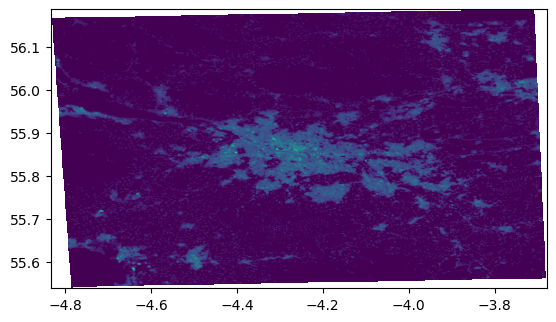

In [8]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [9]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [10]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        # with fiona.open(f"output/{place}/height_cells.shp", 'w', 
        #                 driver='ESRI Shapefile',
        #                 crs=src.crs,
        #                 schema=schema) as dst:
            
        #     # Iterate over each pixel in the raster
        #     for row in tqdm(range(image.shape[0])):
        #         for col in range(image.shape[1]):
        #             value = image[row, col]
        #             polygon = get_cell_polygon(col, row, transform)
        #             dst.write({
        #                 'properties': {'raster_val': int(value)},
        #                 'geometry': mapping(polygon)
        #             })
        
        # List to hold each feature
        features = []

        # Iterate over each pixel in the raster
        for row in tqdm(range(image.shape[0])):
            for col in range(image.shape[1]):
                value = image[row, col]
                polygon = get_cell_polygon(col, row, transform)
                features.append({
                    'properties': {'raster_val': int(value)},
                    'geometry': polygon
                })

        # Create a GeoDataFrame
        area_of_interest = gpd.GeoDataFrame([f['properties'] for f in features],
                            geometry=[f['geometry'] for f in features],
                            crs=src.crs)
        
        area_of_interest.to_parquet(f"output/{place}/height_cells.shp")


100%|██████████| 652/652 [00:17<00:00, 36.64it/s]


# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [11]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Create a 50 km buffer around the point
buffer = gdf_utm.buffer((radius+5)*1000)  # 30 km buffer

# Reproject buffer back to original CRS
buffer = buffer.to_crs(epsg=crs)

# Plottin
buffer.explore()



In [12]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [13]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [14]:
# selected_features_union.plot()

In [15]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [16]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

/tmp/ipykernel_28960/1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [17]:
world_poly = gpd.read_file("input/glasgow_study_area.shp")

In [18]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_28960/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [19]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [20]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [21]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

<Axes: >

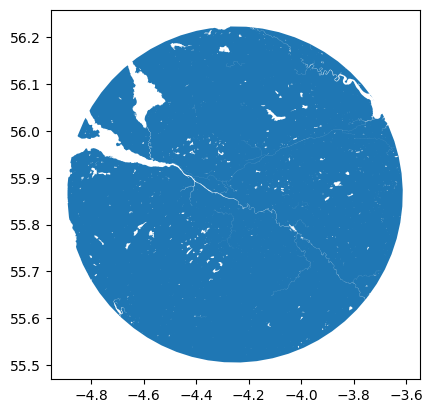

In [22]:
buffer.plot()

In [23]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [24]:
buffer_new = buffer.dissolve()

In [25]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

In [26]:
buffer_new = buffer.dissolve()

In [38]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

osmid  \
u        v          key                                                      
352592   42205832   0                                              5654812   
         352600     0                                             22922763   
         246854925  0    [367005287, 22922762, 22927499, 4000367, 43843...   
42205832 42205836   0                                            306102407   
         3709822659 0                                            306102407   

                         oneway lanes    ref        highway maxspeed reversed  \
u        v          key                                                         
352592   42205832   0      True     1    M74  motorway_link   70 mph    False   
         352600     0      True     2    M74       motorway   70 mph    False   
         246854925  0      True     2    M74       motorway   70 mph    False   
42205832 42205836   0      True     1  B7078      secondary   60 mph    False   
         3709822659 0      True     1  B7078      secondary   60 mph    False   

                           length  \
u        v          key             
352592   42205832   0     509.952   
         352600     0    1307.131   
         246854925  0    6424.129   
42205832 42205836   0       5.638   
         3709822659 0      25.028   

                                                                  geometry  \
u        v          key                                                      
352592   42205832   0    LINESTRING (281404.570 640811.019, 281363.760 ...   
         352600     0    LINESTRING (281404.570 640811.019, 281367.172 ...   
         246854925  0    LINESTRING (284506.366 635214.170, 284439.381 ...   
42205832 42205836   0    LINESTRING (281068.195 641181.777, 281063.908 ...   
         3709822659 0    LINESTRING (281072.594 641205.254, 281074.015 ...   

                               from        to bridge    junction name access  \
u        v          key                                                        
352592   42205832   0        352592  42205832    NaN         NaN  NaN    NaN   
         352600     0        352592    352600    NaN         NaN  NaN    NaN   
         246854925  0     246854925    352592    yes         NaN  NaN    NaN   
42205832 42205836   0      42205832  42205836    NaN  roundabout  NaN    NaN   
         3709822659 0    3709822659  42205832    NaN  roundabout  NaN    NaN   

                        width tunnel est_width service  
u        v          key                                 
352592   42205832   0     NaN    NaN       NaN     NaN  
         352600     0     NaN    NaN       NaN     NaN  
         246854925  0     NaN    NaN       NaN     NaN  
42205832 42205836   0     NaN    NaN       NaN     NaN  
         3709822659 0     NaN    NaN       NaN     NaN

In [39]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [40]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [41]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

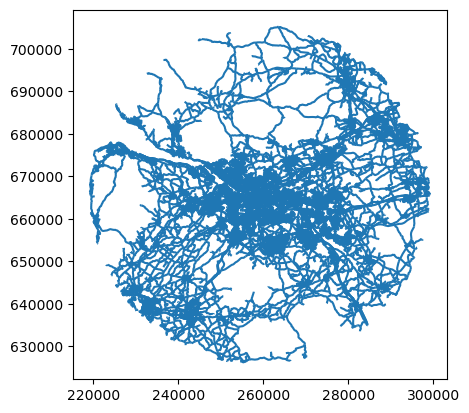

In [42]:
streets_noded_gdf.plot()

In [48]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()



osmid   ref  \
u          v           key                                           
1842571264 977442469   0     [23732219, 672083084, 23732221]  WCM2   
977442469  3716380329  0                           367750394   NaN   
           10675054959 0    [367792696, 23732219, 367750397]  WCM2   
2958608385 8990454777  0                           134959092  SCM2   
           2958608391  0                           134959092  SCM2   

                                                  name          maxspeed  \
u          v           key                                                 
1842571264 977442469   0          West Coast Main Line  [80 mph, 75 mph]   
977442469  3716380329  0                           NaN            40 mph   
           10675054959 0          West Coast Main Line            75 mph   
2958608385 8990454777  0    Scottish Central Main Line               NaN   
           2958608391  0    Scottish Central Main Line               NaN   

                            oneway reversed    length bridge  \
u          v           key                                     
1842571264 977442469   0     False    False  1399.386    yes   
977442469  3716380329  0     False    False    46.784    NaN   
           10675054959 0     False    False   308.363    yes   
2958608385 8990454777  0     False     True   336.196    NaN   
           2958608391  0     False    False    58.394    NaN   

                                                                     geometry  \
u          v           key                                                      
1842571264 977442469   0    LINESTRING (262742.154 661594.704, 262786.537 ...   
977442469  3716380329  0    LINESTRING (262785.521 661576.778, 262742.154 ...   
           10675054959 0    LINESTRING (262441.812 661668.599, 262524.429 ...   
2958608385 8990454777  0    LINESTRING (275080.529 660047.137, 275073.519 ...   
           2958608391  0    LINESTRING (275023.800 660437.854, 275025.092 ...   

                                   from          to    service tunnel  
u          v           key                                             
1842571264 977442469   0      977442469  1842571264        NaN    NaN  
977442469  3716380329  0     3716380329   977442469  crossover    NaN  
           10675054959 0    10675054959   977442469        NaN    NaN  
2958608385 8990454777  0     8990454777  2958608385        NaN    NaN  
           2958608391  0     2958608391  2958608385        NaN    NaN

In [55]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

In [62]:
# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))

In [63]:
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

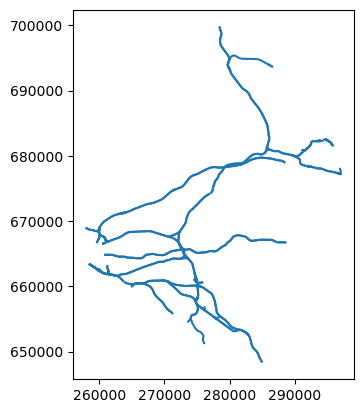

In [64]:
rail_noded_gdf.plot()

In [65]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

rail_noded_gdf.to_parquet(f"./output/{place}/rail_raw.pq")

<Axes: >

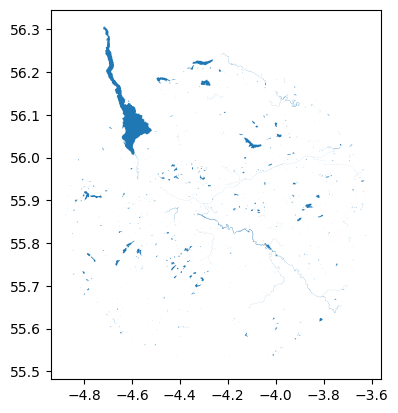

In [66]:
water_gdf.plot()

In [67]:
water_gdf.to_parquet(f"./output/{place}/water.pq")